# OM4 Evaluation plots for VESRI meeting

From Laure:
- KE for truth + emulators and a normalized error for a range of depths, with same colorbars
- Temperature  for truth + emulators and a normalized error for a range of depths, with same colorbars
- Depth integrated Temperature map   for truth + emulators and a normalized error for a range of depths, with same colorbars
- Depth integrated KE  map   for truth + emulators and a normalized error for a range of depths, with same colorbars

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# !pip install -e /home/jovyan/PROJECTS/ocean_emulators

In [4]:
from distributed import Client
client = Client()
client

/srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45563 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/jbusecke/proxy/45563/status,
Dashboard: /user/jbusecke/proxy/45563/status,Workers: 8
Total threads: 64,Total memory: 503.88 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45857,Workers: 8
Dashboard: /user/jbusecke/proxy/45563/status,Total threads: 64
Started: Just now,Total memory: 503.88 GiB
Comm: tcp://127.0.0.1:43299,Total threads: 8
Dashboard: /user/jbusecke/proxy/45081/status,Memory: 62.99 GiB
Nanny: tcp://127.0.0.1:35589,


In [5]:
import xarray as xr
import matplotlib.pyplot as plt
from xarrayutils.plotting import linear_piecewise_scale
# this is janky. Somehow importing xarrayutils disables this...
%matplotlib inline 
from ocean_emulators.postprocessing import post_processor, prediction_data_test
from ocean_emulators.preprocessing import manual_v0_fixes

In [6]:
open_kwargs = dict(engine="zarr", chunks={})
import numpy as np

ds_input = xr.open_dataset("gs://leap-persistent/sd5313/input_OM4v0.0", **open_kwargs)
ds_input = manual_v0_fixes(ds_input)

ds_truth = ds_input.isel(time=slice(4141, 4741))  # will this always be the same?


# load data, postprocess (this should happen on the HPC side)
prediction_paths = [
    "leap-persistent/sd5313/convnext_epoch-15_train-OM4v0.0_eval-OM4v0.0",
    "leap-persistent/sd5313/convnext_epoch-50_train-OM4v0.0_eval-OM4v0.0",
    "leap-persistent/sd5313/convnext_epoch-5_train-OM4v0.0_eval-OM4v0.0",
    "leap-persistent/sd5313/convnext_epoch-best_train-OM4v0.0_eval-OM4v0.0",
]

datasets = []
for path in prediction_paths:
    ds = post_processor(xr.open_dataset("gs://" + path, **open_kwargs), ds_truth)
    print(path)
    prediction_data_test(ds, ds_input)
    epoch = path.split('/')[-1].split('_')[1].replace('epoch-', '')
    ds = ds.assign_coords(epoch=xr.DataArray([epoch], dims=['epoch']))
    datasets.append(ds)
ds_prediction = xr.concat(datasets, dim='epoch')
ds_prediction

/home/jovyan/PROJECTS/ocean_emulators/ocean_emulators/postprocessing.py:13: UserWarning: Swapped x and y dimensions detected. Fixing this now, but should be corrected upstream
  warnings.warn(


leap-persistent/sd5313/convnext_epoch-15_train-OM4v0.0_eval-OM4v0.0


/home/jovyan/PROJECTS/ocean_emulators/ocean_emulators/postprocessing.py:13: UserWarning: Swapped x and y dimensions detected. Fixing this now, but should be corrected upstream
  warnings.warn(


leap-persistent/sd5313/convnext_epoch-50_train-OM4v0.0_eval-OM4v0.0


/home/jovyan/PROJECTS/ocean_emulators/ocean_emulators/postprocessing.py:13: UserWarning: Swapped x and y dimensions detected. Fixing this now, but should be corrected upstream
  warnings.warn(


leap-persistent/sd5313/convnext_epoch-5_train-OM4v0.0_eval-OM4v0.0


/home/jovyan/PROJECTS/ocean_emulators/ocean_emulators/postprocessing.py:13: UserWarning: Swapped x and y dimensions detected. Fixing this now, but should be corrected upstream
  warnings.warn(


leap-persistent/sd5313/convnext_epoch-best_train-OM4v0.0_eval-OM4v0.0


<xarray.Dataset> Size: 118GB
Dimensions:    (epoch: 4, time: 600, y: 180, x: 360, lev: 19)
Coordinates:
    areacello  (y, x) float64 518kB dask.array<chunksize=(90, 360), meta=np.ndarray>
    dz         (lev) int64 152B 5 10 15 20 30 50 ... 500 600 800 1000 1000 1000
    wetmask    (lev, y, x) bool 1MB False False False ... False False False
  * x          (x) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * y          (y) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lev        (lev) float64 152B 2.5 10.0 22.5 40.0 ... 4e+03 5e+03 6e+03
  * time       (time) object 5kB 2014-09-25 12:00:00 ... 2022-12-09 12:00:00
  * epoch      (epoch) <U4 64B '15' '50' '5' 'best'
Data variables:
    uo         (epoch, time, y, x, lev) float64 24GB dask.array<chunksize=(1, 75, 23, 45, 10), meta=np.ndarray>
    vo         (epoch, time, y, x, lev) float64 24GB dask.array<chunksize=(1, 75, 23, 45, 1), meta=np.ndarray>
    thetao     (epoch, time, y, x, lev) float64 24GB dask.array<chunksize=(1, 75, 23, 45, 2), meta=np.ndarray>
    so         (epoch, time, y, x, lev) float64 24GB dask.array<chunksize=(1, 75, 23, 45, 3), meta=np.ndarray>
    zos        (epoch, time, y, x, lev) float64 24GB dask.array<chunksize=(1, 75, 23, 45, 19), meta=np.ndarray>

## OHC maps

In [58]:
def raw_ohc(ds):
    c_p = 3850 #J/(kg C) 
    rho_0 = 1025 #kg/m^3
    ohc = ds.thetao * c_p * rho_0 #C*J/(kg C)*kg/m^3 = J/m^3
    return ohc

def vertical_ohc(ds):
    ohc_raw = raw_ohc(ds)
    ohc_intz = ohc_raw.weighted(ds.dz).sum('lev')
    # multiply by area to get Joules
    ohc_intz = ohc_intz * ds.areacello
    return ohc_intz

ohc_truth = vertical_ohc(ds_truth)
ohc_prediction = vertical_ohc(ds_prediction)

ohc_truth_timeseries = ohc_truth.sum(['x','y']).load()
ohc_prediction_timeseries = ohc_prediction.sum(['x','y']).load()

Text(0.5, 1.0, 'Integrated OHC')

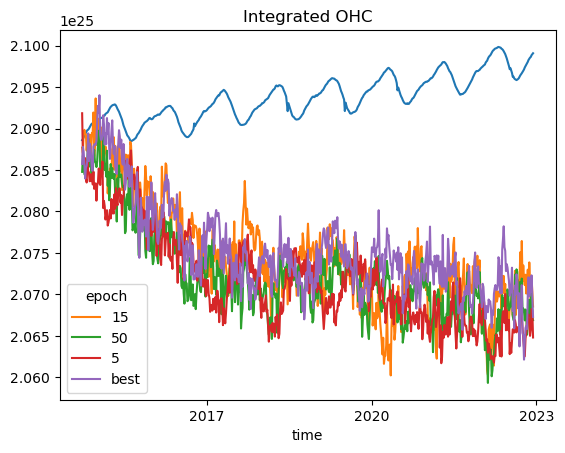

In [59]:
# plot timeseries of the 'raw' OHC
ohc_truth_timeseries.plot()
ohc_prediction_timeseries.plot(hue='epoch')
plt.title("Integrated OHC")

In [60]:
def ohc_map(ohc_intz):
    # return last 5 years - first 5 years
    return ohc_intz.isel(time=slice(-73, None)).mean('time')-ohc_intz.isel(time=slice(0, 73)).mean('time')

ohc_truth_map = ohc_map(ohc_truth).load()
ohc_prediction_map = ohc_map(ohc_prediction).load()

Text(0.5, 1.0, 'Difference (predicted-truth)')

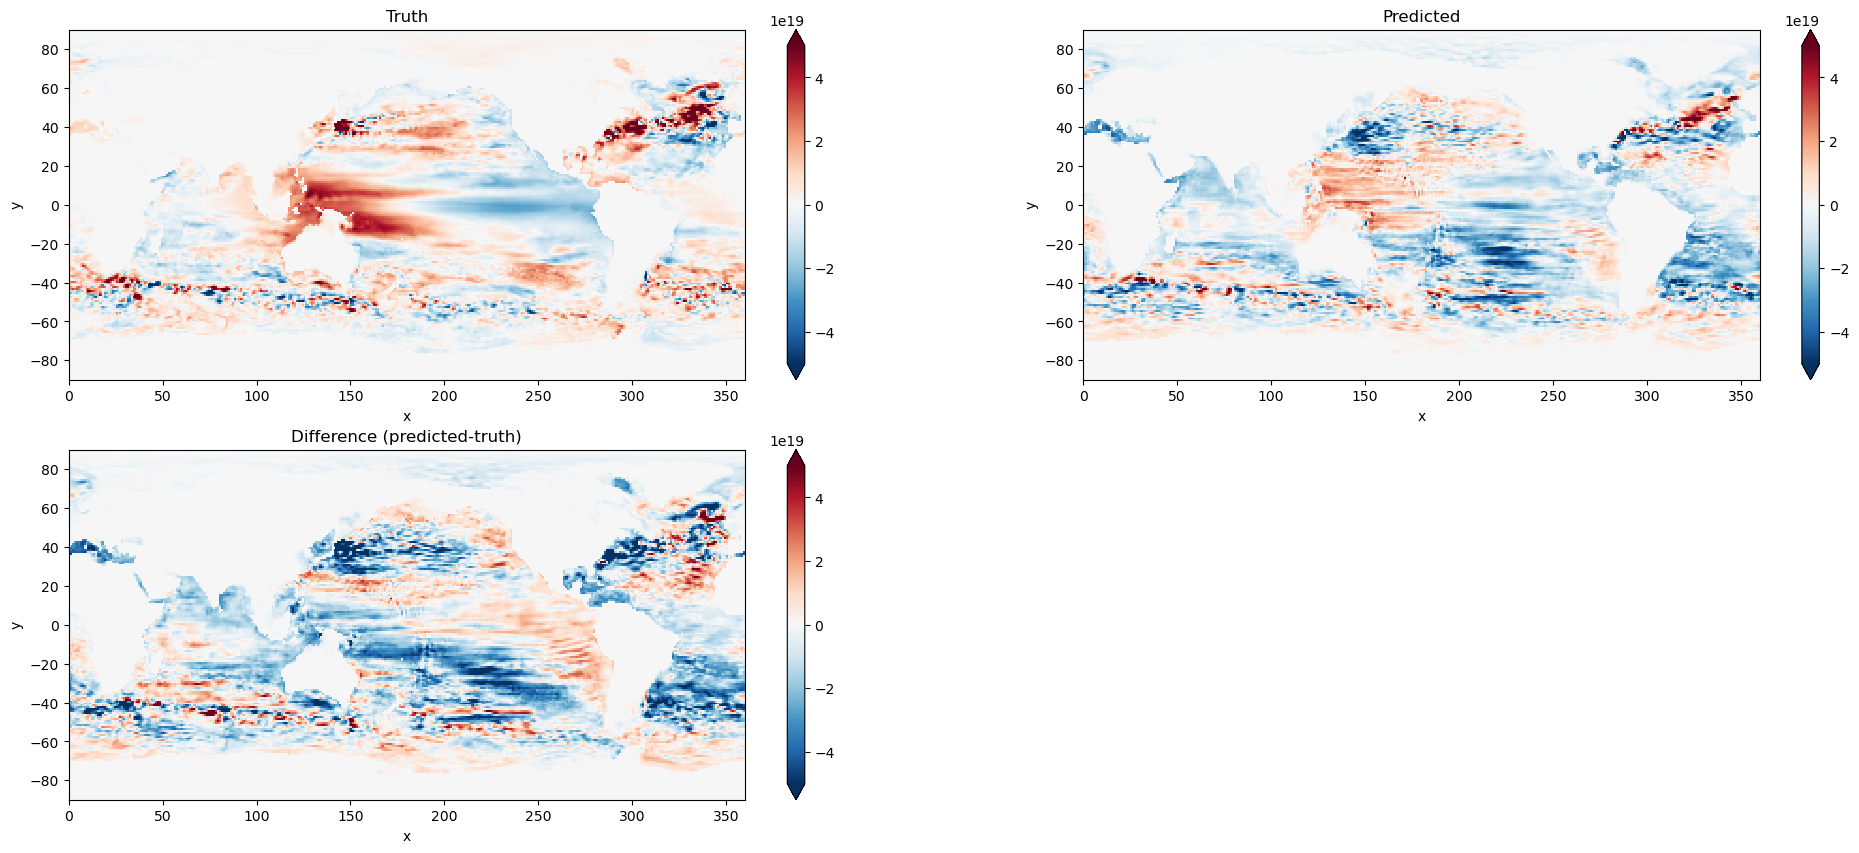

In [61]:
vmax = 5e19
plt.figure(figsize=[24, 10])
plt.subplot(2,2,1)
ohc_truth_map.plot(vmax=vmax)
plt.title('Truth')

plt.subplot(2,2,2)
ohc_prediction_map.sel(epoch='best').plot(vmax=vmax)
plt.title('Predicted')

plt.subplot(2,2,3)
(ohc_prediction_map.sel(epoch='best') - ohc_truth_map).plot(vmax=vmax)
plt.title('Difference (predicted-truth)')

## Heat content profiles

In [65]:
def ohc_profile(ds):
    ohc_raw = raw_ohc(ds)
    # multiply with dz to get extensive quantity
    ohc = ohc_raw * ohc_raw.dz
    return ohc.weighted(ohc['areacello']).sum(['x', 'y'])

ohc_profile_truth = ohc_profile(ds_truth).load()
ohc_profile_prediction = ohc_profile(ds_prediction).load()

Text(0.5, 1.0, 'OHC per layer - Predicted')

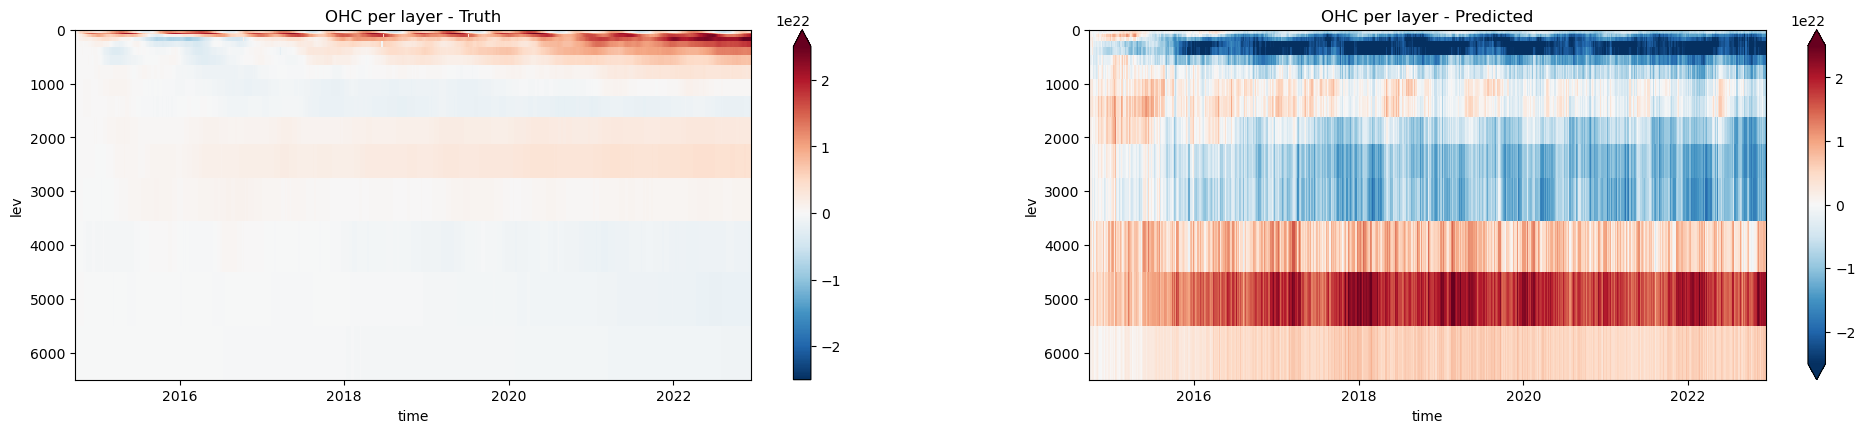

In [72]:
kwargs = dict(yincrease=False, x='time', vmax = 2.5e22)
plt.figure(figsize=[24, 10])
plt.subplot(2,2,1)
(ohc_profile_truth-ohc_profile_truth.isel(time=0)).plot(**kwargs)
plt.title('OHC per layer - Truth')

plt.subplot(2,2,2)
(ohc_profile_prediction-ohc_profile_prediction.isel(time=0)).sel(epoch='best').plot(**kwargs)
plt.title('OHC per layer - Predicted')

## Average temperature over depth

In [6]:
def mean_profile(ds):
    return ds.weighted(ds.areacello).mean(['x','y'])

In [19]:
profile_prediction = mean_profile(ds_prediction).load()
profile_truth = mean_profile(ds_truth).load()

/srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 19.59 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


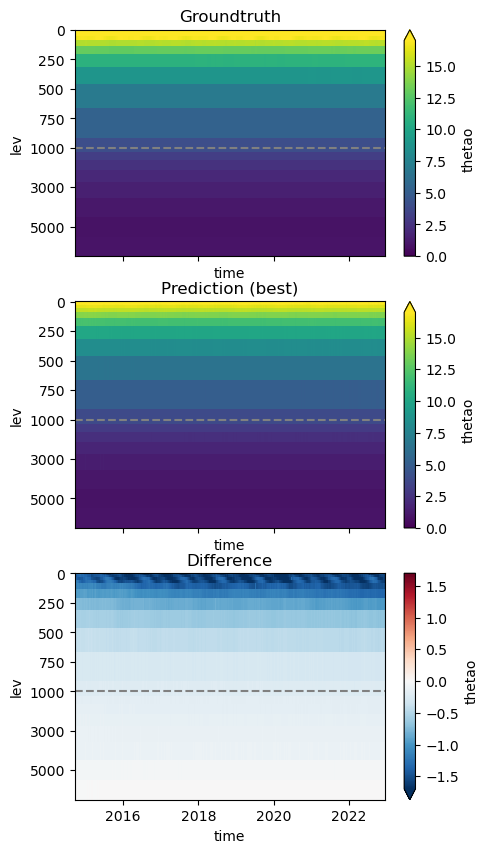

In [68]:
abs_color = {'thetao':([0, 17], 'viridis')}
anomaly_color = {'thetao':([-1.7, 1.7], 'RdBu_r')}
def adjust_depth(ax):
    # todo make split vertical axes
    linear_piecewise_scale(1000, 5, ax=ax)
    # indicate the point between the different scalings
    ax.axhline(1000, color="0.5", ls="--")
    # Rearange the yticks
    ax.set_yticks([0, 250, 500, 750, 1000, 3000, 5000])
    

for v in ['thetao']:
    fig, axarr = plt.subplots(nrows=3, ncols=1, figsize=[5, 10], sharex=True)
    for (ds_profile, title, color_dict), ax in zip([
        (profile_truth, "Groundtruth", abs_color), 
        (profile_prediction.sel(epoch='best'), "Prediction (best)", abs_color),
        (profile_prediction.sel(epoch='best')-profile_truth, "Difference", anomaly_color)
    ], axarr.flat):
        (vmin, vmax), cmap = color_dict[v]
        # plot the truth
        kwargs = dict(x='time',yincrease=False)
        ds_profile[v].plot(ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, **kwargs)
        adjust_depth(ax)
        ax.set_title(title)

In [11]:
# # i need to test 2d and 3d separately
# def split_2d_3d(ds:xr.Dataset):
#     ds_2d = xr.Dataset({v:ds[v] for v in ds.data_vars if 'lev' not in ds[v].dims})
#     ds_3d = xr.Dataset({v:ds[v] for v in ds.data_vars if 'lev' in ds[v].dims})
#     return ds_2d, ds_3d

# def find_index_for_true(da_bool: xr.DataArray):
#     """Find slices along all dimensions within a boolean array that have any True value"""
#     # all_dims = da_bool.dims
#     all_dims = [di for di in ['variable', 'time'] if di in da_bool.dims] # all variables that should be checked for indexers
#     # not necessary to check e.g. x,y, lev here
#     true_found_index = {}
#     for dim in all_dims:
#         other_dims = [di for di in da_bool.dims if di != dim]        test = da_bool.any(other_dims).load()
#         index = da_bool[dim].isel({dim:test})
#         true_found_index[dim] = index.data
#     return true_found_index 

# def test_nan_consistency(ds:xr.Dataset, name='None'):
#     """Test the consistency of nan values in the dataset across variables and time 
#     (compared to a reference at time=0)."""
#     ds = ds.to_array()
#     ref = ds.isel(time=0)
#     # # make sure the ref data has nans in the same places for all variables
#     a = (np.isnan(ref.isel(variable=0)) != np.isnan(ref)).all(['variable'])
    
#     # find the index values for true values in b
#     index = find_index_for_true(a)
#     if not all(len(v) == 0 for v in index.values()):
#         raise ValueError(f"Found non-matching nan values between variables on the first time step.")
    
#     ## make sure that the ref nan pattern is the same as every time step
#     b = np.isnan(ref) != np.isnan(ds)
    
#     # find the index values for true values in b
#     index = find_index_for_true(b)
    
#     # if they are all length 0 all is good, otherwise raise.
#     if not all(len(v) == 0 for v in index.values()):
#         raise ValueError(f"{name}:Found nonmatching nans compared to first time step in the following indexes {index}")

# ds_nan_test_2d, ds_nan_test_3d = split_2d_3d(ds_input) 
# print('2D consistency check')
# test_nan_consistency(ds_nan_test_2d, '2D nan consistency check')

# print('3D consistency check')
# test_nan_consistency(ds_nan_test_3d, '3D nan consistency check')

# # if this passes, the last thing to do is to compare the nan concistency between 2d and 3d
# # merge the first two timesteps and test again
# cross_nan_test = xr.merge([ds_nan_test_2d.isel(time=slice(0,2)), ds_nan_test_3d.isel(lev=0, time=slice(0,2))])
# test_nan_consistency(cross_nan_test, 'Cross nan consistency check')

2D consistency check
<xarray.DataArray (variable: 4, y: 180, x: 360, time: 4745)> Size: 1GB
dask.array<ne, shape=(4, 180, 360, 4745), dtype=bool, chunksize=(1, 180, 360, 1), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) object 38kB 1958-01-03 12:00:00 ... 2022-12-29 12:00:00
  * x          (x) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * y          (y) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    areacello  (y, x) float64 518kB dask.array<chunksize=(90, 360), meta=np.ndarray>
  * variable   (variable) object 32B 'hfds' 'tauuo' 'tauvo' 'zos'
<xarray.DataArray (variable: 4, y: 180, x: 360, time: 4745)> Size: 1GB
dask.array<ne, shape=(4, 180, 360, 4745), dtype=bool, chunksize=(1, 180, 360, 1), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) object 38kB 1958-01-03 12:00:00 ... 2022-12-29 12:00:00
  * x          (x) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * y          (y) float64 1kB -89.5 -88.5 -87.5 -86.

ValueError: 3D nan consistency check:Found nonmatching nans compared to first time step in the following indexes {'variable': array(['thetao', 'vo'], dtype=object), 'time': array([cftime.DatetimeJulian(1959, 8, 26, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2006, 8, 31, 12, 0, 0, 0, has_year_zero=False)],
      dtype=object)}

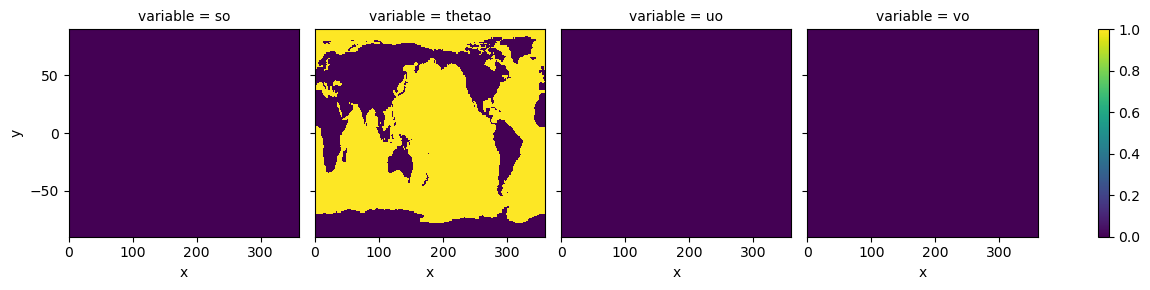

In [133]:
(np.isnan(ref) != np.isnan(ds_nan_test.sel(time='1959-08-26'))).isel(lev=5).plot(col='variable')

## Changes in temperature predicted at some levels with training

NameError: name 'profile_truth' is not defined

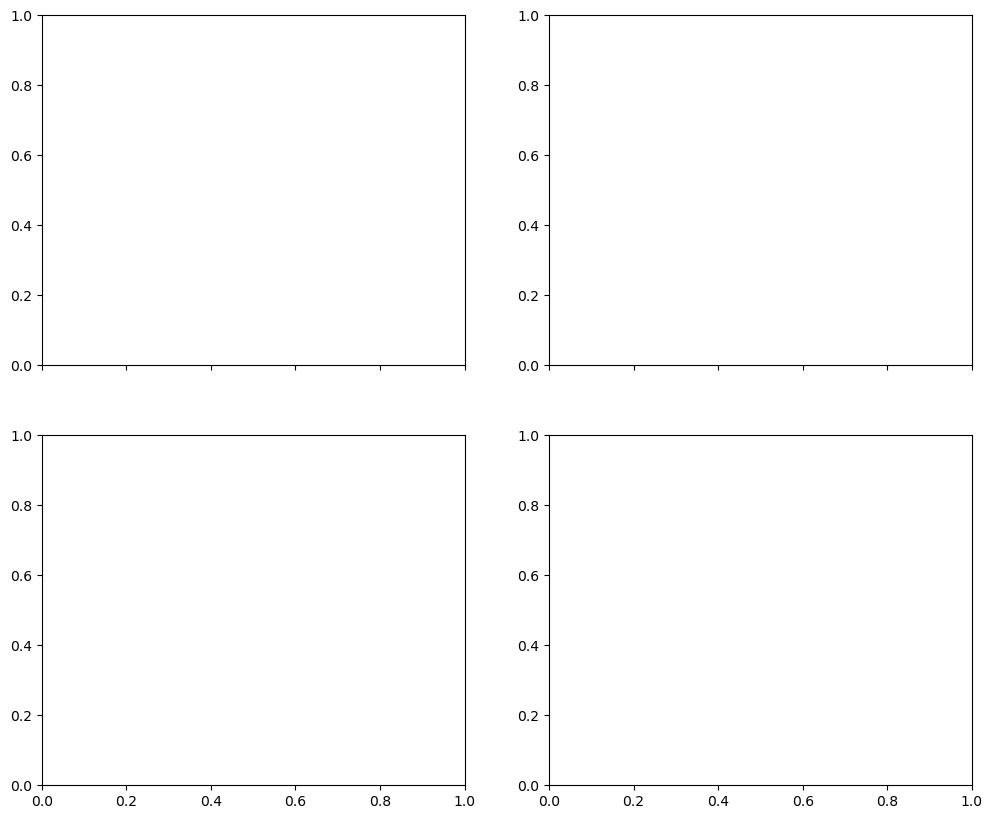

In [73]:
for v in ['thetao']:
    fig, axarr = plt.subplots(nrows=2, ncols=2, figsize=[12, 10], sharex=True)
    for lev, ax in zip([2.5, 40, 250, 1050], axarr.flat):
        kwargs = dict(x='time', ax=ax)
        profile_truth[v].sel(lev=lev).plot(color='k', ls='--', **kwargs)
        profile_prediction[v].sel(lev=lev).plot(hue='epoch', **kwargs)
        ax.set_title(f"Depth: {lev}")

## Vertically integrated maps (averaged over last 2 years)

In [ ]:
def vertical_integral(ds):
    return ds.isel(time=slice(-(72*2), None)).weighted(ds.dz).sum(['lev']).mean('time')

int_map_prediction = vertical_integral(ds_prediction).load()
int_map_truth = vertical_integral(ds_truth).load()